In [1]:
# !conda install -c conda-forge matplotlib -y

In [33]:
import pandas as pd
import matplotlib as plt
import dpcrawler
import numpy as np

In [3]:
avadf = pd.read_csv('AVA.txt', sep=" ", header=None, index_col=0)
avadf.columns = ["id", "r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9", "r10", "sem1", "sem2", "challenge"]

In [4]:
avadf.head()

,id,r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,sem1,sem2,challenge
0,,,,,,,,,,,,,,
1,953619,0,1,5,17,38,36,15,6,5,1,1,22,1396
2,953958,10,7,15,26,26,21,10,8,1,2,1,21,1396
3,954184,0,0,4,8,41,56,10,3,4,0,0,0,1396
4,954113,0,1,4,6,48,37,23,5,2,2,15,21,1396
5,953980,0,3,6,15,57,39,6,1,1,1,22,38,1396


In [5]:
ratecols = ["r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9", "r10"]

In [6]:
avadf['count of ratings'] = avadf[ratecols].sum(axis=1)

In [7]:
avadf['avg rate'] = (avadf['r1']*1+avadf['r2']*2+avadf['r3']*3+avadf['r4']*4+avadf['r5']*5+avadf['r6']*6+avadf['r7']*7+avadf['r8']*8+avadf['r9']*9+avadf['r10']*10)/avadf['count of ratings']

In [8]:
avadf.head()

,id,r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,sem1,sem2,challenge,count of ratings,avg rate
0,,,,,,,,,,,,,,,,
1,953619,0,1,5,17,38,36,15,6,5,1,1,22,1396,124,5.637097
2,953958,10,7,15,26,26,21,10,8,1,2,1,21,1396,126,4.698413
3,954184,0,0,4,8,41,56,10,3,4,0,0,0,1396,126,5.674603
4,954113,0,1,4,6,48,37,23,5,2,2,15,21,1396,128,5.773438
5,953980,0,3,6,15,57,39,6,1,1,1,22,38,1396,129,5.209302


<AxesSubplot:>

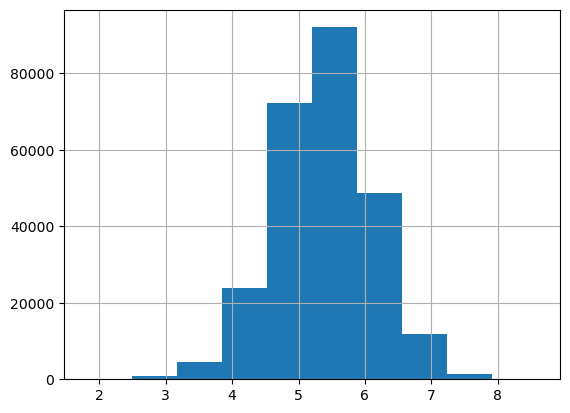

In [9]:
avadf['avg rate'].hist()

In [10]:
avadf_subset = avadf[1:100]

<AxesSubplot:>

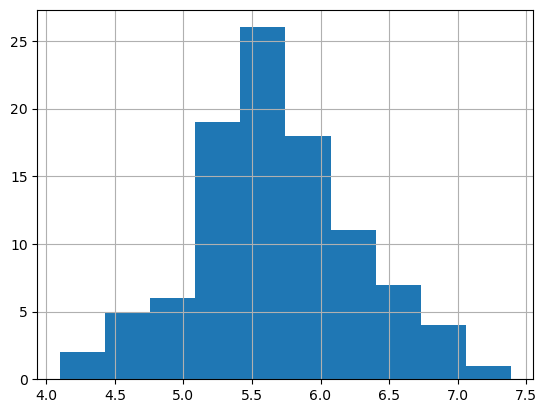

In [11]:
avadf_subset['avg rate'].hist()

In [12]:
avadf_subset['id'].iloc[0]

953958

In [13]:
imgid = avadf_subset['id'].iloc[0]
url = dpcrawler.getPhotoURLByID(imgid)

In [14]:
url

'http://images.dpchallenge.com/images_challenge/1000-1999/1396/1200/Copyrighted_Image_Reuse_Prohibited_953958.jpg'

In [15]:
dpcrawler.savePhotoByUrl(url,imgid)

'953958.jpg'

In [16]:
import os
import torch
import torch.nn as nn
from os.path import expanduser  # pylint: disable=import-outside-toplevel
from urllib.request import urlretrieve  # pylint: disable=import-outside-toplevel
def get_aesthetic_model(clip_model="vit_l_14"):
    """load the aethetic model"""
    home = expanduser("~")
    cache_folder = home + "/.cache/emb_reader"
    path_to_model = cache_folder + "/sa_0_4_"+clip_model+"_linear.pth"
    if not os.path.exists(path_to_model):
        os.makedirs(cache_folder, exist_ok=True)
        url_model = (
            "https://github.com/LAION-AI/aesthetic-predictor/blob/main/sa_0_4_"+clip_model+"_linear.pth?raw=true"
        )
        urlretrieve(url_model, path_to_model)
    if clip_model == "vit_l_14":
        m = nn.Linear(768, 1)
    elif clip_model == "vit_b_32":
        m = nn.Linear(512, 1)
    else:
        raise ValueError()
    s = torch.load(path_to_model)
    m.load_state_dict(s)
    m.eval()
    return m

amodel= get_aesthetic_model(clip_model="vit_l_14")
amodel.eval()

import torch
from PIL import Image
import open_clip
model, _, preprocess = open_clip.create_model_and_transforms('ViT-L-14', pretrained='openai')

In [17]:
def rateImg(path):
    image = preprocess(Image.open(path)).unsqueeze(0)
    with torch.no_grad():
        image_features = model.encode_image(image)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        return amodel(image_features)

In [18]:
def getAndRateImg(imgid):
    url = dpcrawler.getPhotoURLByID(imgid)
    path = dpcrawler.savePhotoByUrl(url,imgid)
    rate = rateImg(path)
    os.remove(path)
    return rate

In [19]:
imgid = avadf_subset['id'].iloc[0]
getAndRateImg(imgid)

tensor([[0.7439]])

In [21]:
avadf_subset['predictor_rates'] = avadf_subset['id'].apply(lambda x: getAndRateImg(x))

/tmp/ipykernel_516779/1746723349.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avadf_subset['predictor_rates'] = avadf_subset['id'].apply(lambda x: getAndRateImg(x))


In [22]:
avadf_subset.head()

,id,r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,sem1,sem2,challenge,count of ratings,avg rate,predictor_rates
0,,,,,,,,,,,,,,,,,
2,953958,10,7,15,26,26,21,10,8,1,2,1,21,1396,126,4.698413,[[tensor(0.7439)]]
3,954184,0,0,4,8,41,56,10,3,4,0,0,0,1396,126,5.674603,[[tensor(5.1817)]]
4,954113,0,1,4,6,48,37,23,5,2,2,15,21,1396,128,5.773438,[[tensor(4.8629)]]
5,953980,0,3,6,15,57,39,6,1,1,1,22,38,1396,129,5.209302,[[tensor(7.2325)]]
6,954175,0,0,5,13,40,53,14,1,3,1,15,65,1396,130,5.600000,[[tensor(5.0148)]]


In [25]:
float(avadf_subset['predictor_rates'].iloc[0])

0.7439360618591309

In [27]:
avadf_subset['predictor_rates'] = avadf_subset['predictor_rates'].apply(lambda x: float(x))

/tmp/ipykernel_516779/1495698367.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avadf_subset['predictor_rates'] = avadf_subset['predictor_rates'].apply(lambda x: float(x))


In [31]:
avadf_subset['predictor_rates'] = avadf_subset['predictor_rates'].apply(lambda x: x/10)

/tmp/ipykernel_516779/2855379439.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avadf_subset['predictor_rates'] = avadf_subset['predictor_rates'].apply(lambda x: x/10)


In [32]:
avadf_subset.head()

,id,r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,sem1,sem2,challenge,count of ratings,avg rate,predictor_rates
0,,,,,,,,,,,,,,,,,
2,953958,10,7,15,26,26,21,10,8,1,2,1,21,1396,126,4.698413,0.743936
3,954184,0,0,4,8,41,56,10,3,4,0,0,0,1396,126,5.674603,5.181679
4,954113,0,1,4,6,48,37,23,5,2,2,15,21,1396,128,5.773438,4.862921
5,953980,0,3,6,15,57,39,6,1,1,1,22,38,1396,129,5.209302,7.232469
6,954175,0,0,5,13,40,53,14,1,3,1,15,65,1396,130,5.600000,5.014781


In [34]:
avadf_subset['rate_diff'] = avadf_subset['predictor_rates']-avadf_subset['avg rate']

/tmp/ipykernel_516779/285962007.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avadf_subset['rate_diff'] = avadf_subset['predictor_rates']-avadf_subset['avg rate']


<AxesSubplot:>

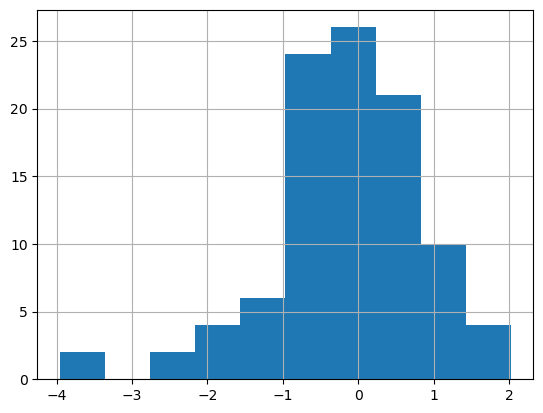

In [35]:
avadf_subset['rate_diff'].hist()

In [36]:
avadf_subset['rate_diff'].describe()

count    99.000000
mean     -0.160691
std       0.999645
min      -3.954477
25%      -0.588214
50%      -0.166770
75%       0.530636
max       2.023166
Name: rate_diff, dtype: float64

In [37]:
avadf_subset['rate_diff_abs'] = np.abs(avadf_subset['rate_diff'])

/tmp/ipykernel_516779/22300486.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avadf_subset['rate_diff_abs'] = np.abs(avadf_subset['rate_diff'])


In [38]:
avadf_subset=avadf_subset.sort_values(by='rate_diff_abs',ascending=False)

In [45]:
avadf_subset.head(20)

,id,r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,sem1,sem2,challenge,count of ratings,avg rate,predictor_rates,rate_diff,rate_diff_abs
0,,,,,,,,,,,,,,,,,,,
2,953958,10,7,15,26,26,21,10,8,1,2,1,21,1396,126,4.698413,0.743936,-3.954477,3.954477
86,953935,0,3,0,14,44,37,20,4,6,0,24,39,1396,128,5.703125,2.338998,-3.364127,3.364127
45,954066,1,2,7,29,45,32,11,1,2,1,1,38,1396,131,5.129771,2.557714,-2.572057,2.572057
75,953097,0,0,0,3,10,24,33,32,15,14,5,19,1396,131,7.389313,5.007585,-2.381728,2.381728
5,953980,0,3,6,15,57,39,6,1,1,1,22,38,1396,129,5.209302,7.232469,2.023166,2.023166
68,954226,9,11,24,28,28,11,5,5,0,0,51,65,1396,121,4.099174,2.220835,-1.878338,1.878338
16,954222,0,1,2,4,18,41,29,17,10,4,9,24,1396,126,6.579365,4.791587,-1.787778,1.787778
66,954014,0,3,7,26,57,19,2,1,1,3,21,38,1396,119,4.966387,3.307117,-1.659270,1.659270
80,954224,0,2,0,8,27,47,26,11,6,3,0,0,1396,130,6.207692,7.852237,1.644544,1.644544


In [44]:
iid = avadf_subset['id'].iloc[0]
print(iid)
url = dpcrawler.getPhotoURLByID(iid)
path = dpcrawler.savePhotoByUrl(url,iid)
path

953958


AttributeError: 'NoneType' object has no attribute 'string'